In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import requests
from bs4 import BeautifulSoup 
#import urllib.request
import zipfile
import io
import os
import datetime as dt
import pycountry as pc
import math

#from pandas.plotting import register_matplotlib_converters
#register_matplotlib_converters()

import locale
locale.setlocale(locale.LC_TIME,"Danish")


'Danish_Denmark.1252'

In [2]:
#Settings for plotting

fs_label = 16

parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label
             }

plt.rcParams.update(parameters)

#locale.setlocale(locale.LC_TIME, "Danish") 

In [3]:
# Danish regional data:

get_data = True
ssidatapath = "ssi_data"
rootdir = os.getcwd() +"/" + ssidatapath


def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

def get_all_data():
    url = "https://covid19.ssi.dk/overvagningsdata/download-fil-med-overvaagningdata"
    #url = "http://www.ssi.dk/covid19/overvagning/data/data-epidemiologisk(e)-rapport-"
    #old link#url = "https://www.ssi.dk/sygdomme-beredskab-og-forskning/sygdomsovervaagning/c/covid19-overvaagning/arkiv-med-overvaagningsdata-for-covid19"
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    links = soup.find_all("a", string=lambda text: "data" in str(text).lower())
    #print(links.index("<a href=\"http://www.ssi.dk/covid19data\" target=\"_blank\">www.ssi.dk/covid19data</a>"))
    #print(links)
    check_str = "<a href=\"https://files.ssi"
    for link in links[3:]: 
        #print(link)
        if str(link)[:len(check_str)]!=check_str:
            print("not a file; continues...")
            continue
        #print(link)
        file = link["href"]
        old_date = str(file).split("-")[-2]
        if len(old_date)!=8:
            print("not a date; continues...")
            continue
        new_date = old_date[4:] + "-" + old_date[2:4] + "-" + old_date[0:2]
        filename = "SSI_data_" + new_date
        zipped_save_path = ssidatapath + "_zipped/" + filename + ".zip"
        extracted_save_path = ssidatapath + "/" + filename
        
        download_url(file, zipped_save_path)
        with zipfile.ZipFile(zipped_save_path, 'r') as zipObj:
            zipObj.extractall(extracted_save_path)

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)+1):
        yield start_date + pd.DateOffset(days=n)

In [4]:
# start_dt = pd.to_datetime("2020-03-01")
# end_dt = pd.to_datetime("2020-05-01")

#for date in daterange(start_dt, end_dt):
    #print(date)
#    print(dt.strftime("%Y-%m-%d"))

if not os.path.exists('figs'):
    os.makedirs('figs')

if get_data:
    os.system("mkdir ssi_data_zipped")
    os.system("mkdir ssi_data")
    get_all_data()

dk_cases_by_age_df = pd.DataFrame()
for subdir, dirs, files in os.walk(rootdir):
    if not len(files) == 0:
        date = pd.to_datetime(subdir[-10:])
        for file in files:
            if file.lower() == "cases_by_age.csv":
                cases_age = pd.read_csv(subdir + "/" + file, sep=";", decimal=",")
                cases_age["Dato"] = date
                cases_age["Antal_bekræftede_COVID-19"] = pd.to_numeric(cases_age["Antal_bekræftede_COVID-19"].astype(str).apply(lambda x: x.replace('.','')))
                cases_age["Antal_testede"] = pd.to_numeric(cases_age["Antal_testede"].astype(str).apply(lambda x: x.replace('.','')))
                dk_cases_by_age_df = dk_cases_by_age_df.append(cases_age, ignore_index=True)
dk_cases_by_age_df = dk_cases_by_age_df.sort_values(by=['Dato', "Aldersgruppe"]).reset_index(drop=True)
dk_cases_by_age_df#.columns
testede_alder = dk_cases_by_age_df.groupby(["Dato", "Aldersgruppe"]).sum()["Antal_testede"].unstack()
bekr_alder = dk_cases_by_age_df.groupby(["Dato", "Aldersgruppe"]).sum()["Antal_bekræftede_COVID-19"].unstack()

# uncomment for daily data:
testede_alder = testede_alder.diff()
bekr_alder = bekr_alder.diff()

if get_data:
    print("Data is loaded")

not a file; continues...
not a file; continues...
not a date; continues...
not a date; continues...
not a date; continues...
not a date; continues...
not a date; continues...
not a file; continues...
not a file; continues...
not a file; continues...
Data is loaded


In [5]:
# Get the most recent date
finalMonth = np.datetime64(testede_alder.index[-1].strftime('%Y-%m'))
monthsToShow = 5
smallRange = np.arange(finalMonth-np.timedelta64(monthsToShow-2,'M'),finalMonth+np.timedelta64(2,'M'))
smallRange

array(['2021-01', '2021-02', '2021-03', '2021-04', '2021-05'],
      dtype='datetime64[M]')

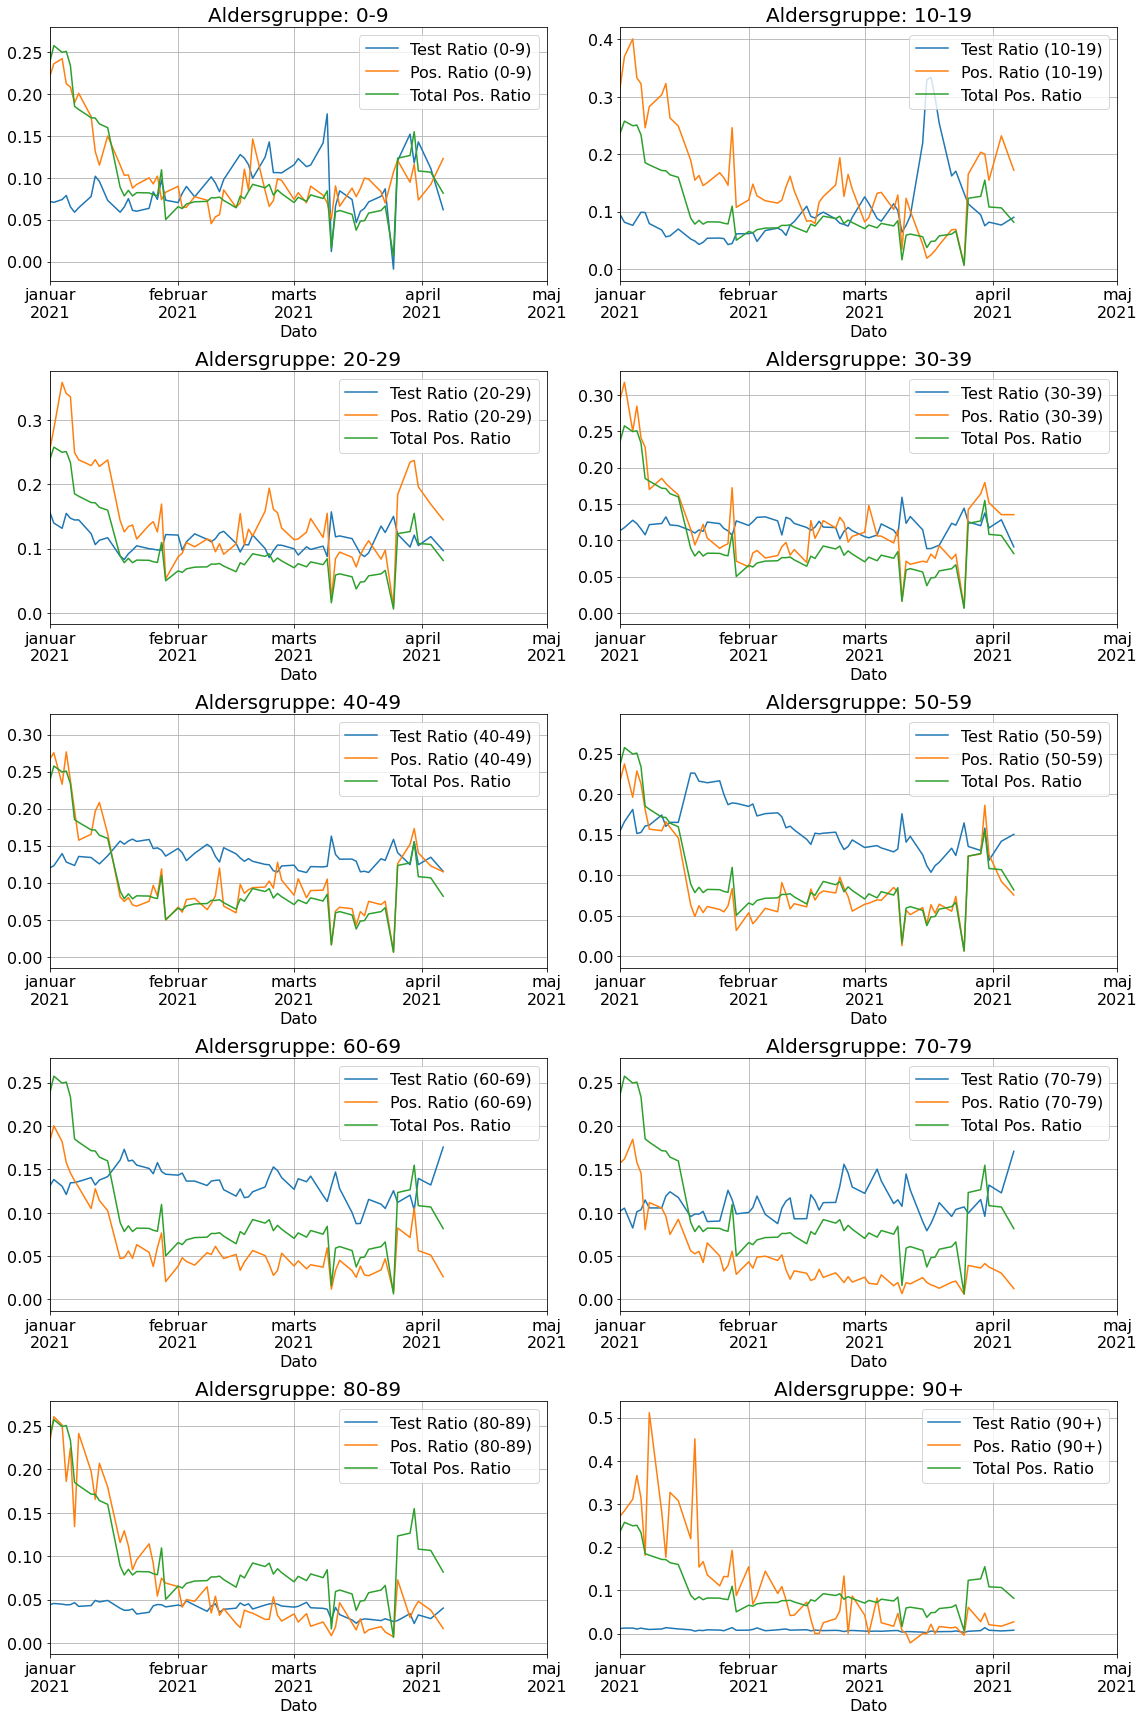

In [6]:
scale = "log"
num_cols = 2
age_groups = testede_alder.drop(columns="I alt").columns
fig, axs = plt.subplots(int(len(age_groups)/num_cols), num_cols, figsize=(16,24))


# all_xticks = np.arange(np.datetime64('2021-01'),np.datetime64('2021-06'))
all_xticks = smallRange
all_xlim = [all_xticks[0],all_xticks[-1]]

for i in range(len(age_groups)):
    col = age_groups[i]
    ax_row = int(i/num_cols)
    ax_col = int(i%num_cols)
    ax = axs[ax_row, ax_col]
    #axs.plot(testede_alder.index, testede_alder[col].diff(), label=col)
    ax.set_title(f"Aldersgruppe: {col}")
    ax.set_xlabel("Dato")
    #ax.set_ylabel("Dato")
    ax.plot(testede_alder.index, testede_alder[col].div(testede_alder["I alt"]), label=f"Test Ratio ({col})")
    ax.plot(bekr_alder.index, bekr_alder[col].div(testede_alder[col]), label=f"Pos. Ratio ({col})")
    ax.plot(bekr_alder.index, bekr_alder["I alt"].div(testede_alder["I alt"]), label=f"Total Pos. Ratio")
    #ticks_loc = ax.get_xticklabels()#.tolist()
    #print(ticks_loc)

    ax.set_xticks(all_xticks)
    # ax.set_xticklabels(all_xticks,rotation=45, ha='right')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%B\n%Y'))
    ax.set_xlim(all_xlim)
    ax.grid(True)

    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    # plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend()
plt.tight_layout()
# plt.set_xticklabels(ticks_loc, rotation=45, ha='right')

plt.savefig("figs/regional_dk_testdata_zoom.pdf")
plt.savefig("figs/regional_dk_testdata_zoom.png")
